# Trabalho Machine Learning I - Santander Coders Data Science 2023

Integrantes:
- Bruno Henrique
- Fernanda Beatriz Dallaqua
- Natália Alves Brito
- Vinícius D' Lucas

In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

from scipy.stats import chi2
from scipy.stats import chi2_contingency

from sklearn.utils import resample

from sklearn.pipeline import Pipeline

from sklearn.metrics import auc
from sklearn.metrics import roc_curve
from sklearn.metrics import recall_score
from sklearn.metrics import precision_score
from sklearn.metrics import matthews_corrcoef
from sklearn.metrics import cohen_kappa_score
from sklearn.metrics import classification_report
from sklearn.metrics import precision_recall_curve
from sklearn.metrics import precision_recall_fscore_support

from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import train_test_split
from sklearn.model_selection import RandomizedSearchCV, GridSearchCV

from sklearn.feature_selection import SelectFromModel

from sklearn.neural_network import MLPClassifier

from sklearn.ensemble import ExtraTreesClassifier
from sklearn.ensemble import RandomForestClassifier

from sklearn.linear_model import LogisticRegression


In [62]:
path_train = 'playground-series-s3e2/train.csv'
df         = pd.read_csv(path_train)
df.head(10)

,id,gender,age,hypertension,heart_disease,ever_married,work_type,Residence_type,avg_glucose_level,bmi,smoking_status,stroke
0,0,Male,28.0,0,0,Yes,Private,Urban,79.53,31.1,never smoked,0
1,1,Male,33.0,0,0,Yes,Private,Rural,78.44,23.9,formerly smoked,0
2,2,Female,42.0,0,0,Yes,Private,Rural,103.00,40.3,Unknown,0
3,3,Male,56.0,0,0,Yes,Private,Urban,64.87,28.8,never smoked,0
4,4,Female,24.0,0,0,No,Private,Rural,73.36,28.8,never smoked,0
5,5,Female,34.0,0,0,Yes,Private,Urban,84.35,22.2,Unknown,0
6,6,Female,53.0,0,0,Yes,Private,Rural,88.97,25.3,never smoked,0
7,7,Male,78.0,0,1,Yes,Self-employed,Rural,75.32,24.8,Unknown,0
8,8,Female,45.0,0,0,Yes,Private,Rural,107.22,34.1,never smoked,0
9,9,Female,62.0,0,0,Yes,Govt_job,Urban,62.68,18.4,formerly smoked,0


In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 15304 entries, 0 to 15303
Data columns (total 12 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   id                 15304 non-null  int64  
 1   gender             15304 non-null  object 
 2   age                15304 non-null  float64
 3   hypertension       15304 non-null  int64  
 4   heart_disease      15304 non-null  int64  
 5   ever_married       15304 non-null  object 
 6   work_type          15304 non-null  object 
 7   Residence_type     15304 non-null  object 
 8   avg_glucose_level  15304 non-null  float64
 9   bmi                15304 non-null  float64
 10  smoking_status     15304 non-null  object 
 11  stroke             15304 non-null  int64  
dtypes: float64(3), int64(4), object(5)
memory usage: 1.4+ MB


O dataset é composto pelas colunas 
<prev>
- id:                id da amostra/paciente
- gender:            gênero do paciente, podendo ser 'Male', 'Female', 'Other'
- hypertension:      se o paciente tem hipertensão (0 não tem, 1 tem)
- heart_disease:     se o paciente tem doença do coração (0 não tem, 1 tem)
- ever_married:      se o paciente já se casou ('Yes' and 'No')
- work_type:         em que setor o paciente trabalha ('Private', 'Self-employed', 'Govt_job', 'children', 'Never_worked') 
- Residence_type:    se o paciente mora em área urbana ou rural ('Urban', 'Rural')
- avg_glucose_level: o nível médio de glicose do paciente (glicemia). É dado por mg/dL (miligrama por decilitro). O valor normal para um jejum de 8 a 12 horas é de 70 a 99 mg/dL, sendo menor uma hipoglicemia, e acima temos alterado para 100 a 125 mg/dL e indicativo de diabetes para valores de 126 mg/dL para cima <sup>1</sup>.
- bmi:               body mass index, ou índice de massa corporal (IMC) do paciente. Esse índice é utilizado para avaliar o grau de sobrepeso e obesidade e é calculado dividindo o peso (em kg) pela altura ao quadrado (em metros). Um valor normal é de 18,6 a 24,9 e pessoas acima de 30 já são consideradas obesas, com grau variando de I a III <sup>2</sup>.  
- smoking_status:    se o paciente já fumou, fuma, nunca fumou, ou desconhecido ('never smoked', 'formerly smoked', 'Unknown', 'smokes')    
</prev>

<sup>1</sup> Fonte: [https://cerpe.com.br/saude/glicose-alta-baixa-normal](https://cerpe.com.br/saude/glicose-alta-baixa-normal) 

<sup>2</sup> Fonte: [https://abeso.org.br/obesidade-e-sindrome-metabolica/calculadora-imc/](https://abeso.org.br/obesidade-e-sindrome-metabolica/calculadora-imc/)

In [4]:
def get_valores_unicos(df, coluna):
    print(f'Os valores únicos para a coluna {coluna} são:')
    print(list(df[coluna].unique()))
    print()

In [5]:
get_valores_unicos(df,'gender')
get_valores_unicos(df,'hypertension')
get_valores_unicos(df,'heart_disease')
get_valores_unicos(df,'ever_married')
get_valores_unicos(df,'work_type')
get_valores_unicos(df,'Residence_type')
get_valores_unicos(df,'smoking_status')
get_valores_unicos(df,'stroke')

Os valores únicos para a coluna gender são:
['Male', 'Female', 'Other']

Os valores únicos para a coluna hypertension são:
[0, 1]

Os valores únicos para a coluna heart_disease são:
[0, 1]

Os valores únicos para a coluna ever_married são:
['Yes', 'No']

Os valores únicos para a coluna work_type são:
['Private', 'Self-employed', 'Govt_job', 'children', 'Never_worked']

Os valores únicos para a coluna Residence_type são:
['Urban', 'Rural']

Os valores únicos para a coluna smoking_status são:
['never smoked', 'formerly smoked', 'Unknown', 'smokes']

Os valores únicos para a coluna stroke são:
[0, 1]



## Estatísticas gerais das colunas age, avg_glucose_level e bmi

In [6]:
df[['age','avg_glucose_level','bmi']].describe()

,age,avg_glucose_level,bmi
count,15304.000000,15304.000000,15304.000000
mean,41.417708,89.039853,28.112721
std,21.444673,25.476102,6.722315
min,0.080000,55.220000,10.300000
25%,26.000000,74.900000,23.500000
50%,43.000000,85.120000,27.600000
75%,57.000000,96.980000,32.000000
max,82.000000,267.600000,80.100000


Podemos notar que as idades estão em um intervalo válido de 0 a 82 anos. A glicemia e o bmi também estão em intervalos válidos, com valores positivos. Pelas fontes citadas acima, pode-se perceber que a média da glicemia está com um valor considerado normal (entre 70 e 99 mg/dL) e o bmi está média 28, o que é considerado como sobrepeso.

A glicemia tem valor máximo de quase 268, o que é considerado perigoso e pode indicar que o paciente está com diabetes. Já o bmi máximo é de 80, o que é considerado obesidade de grau III, em que há grande probabilidade da pessoa já ter doenças muito graves.

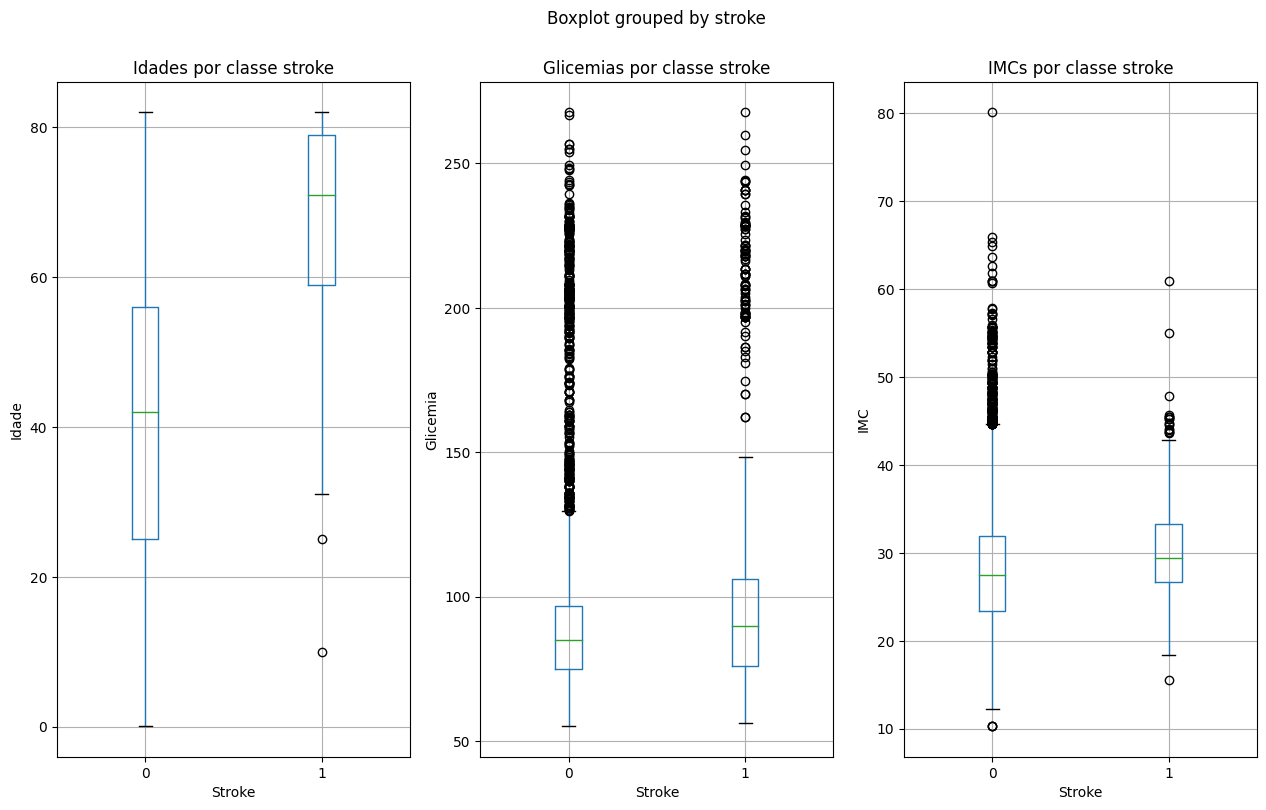

In [7]:
fig, ax = plt.subplots(nrows=1,ncols=3,figsize=(15,9))
df.boxplot(column='age', by="stroke", ax=ax[0], grid=True)
ax[0].set_title('Idades por classe stroke')
ax[0].set_ylabel('Idade')
ax[0].set_xlabel('Stroke')

df.boxplot(column='avg_glucose_level', by="stroke", ax=ax[1], grid=True)
ax[1].set_title('Glicemias por classe stroke')
ax[1].set_ylabel('Glicemia')
ax[1].set_xlabel('Stroke')

df.boxplot(column='bmi', by="stroke", ax=ax[2], grid=True)
ax[2].set_title('IMCs por classe stroke')
ax[2].set_ylabel('IMC')
ax[2].set_xlabel('Stroke')

plt.show();

# EXPLICAR BOXPLOTS AQUI

## Analisando as distribuições

In [8]:
def plot_histogramas(dataframe: pd.DataFrame, coluna: str) -> None:
    fig, ax = plt.subplots(nrows=1, ncols=3, figsize=(15,9))

    sns.histplot(data=dataframe, x=coluna,ax=ax[0], kde=True);
    ax[0].set_title(f'Histograma geral de {coluna}')
    ax[0].set_xlabel(coluna)
    ax[0].set_ylabel('Número de ocorrências');

    ax[0].axvline(df[coluna].mean(), color='b', linestyle='dashed', linewidth=2, label='Média')
    ax[0].axvline(df[coluna].median(), color='r', linestyle='dashed', linewidth=2, label='Mediana')

    sns.histplot(data=dataframe[dataframe['stroke']==0], x=coluna,ax=ax[1], kde=True);
    ax[1].set_title('Histograma stroke 0')
    ax[1].set_xlabel(coluna)
    ax[1].set_ylabel('Número de ocorrências');

    ax[1].axvline(dataframe[dataframe['stroke']==0][coluna].mean(), color='b', linestyle='dashed', linewidth=2, label='Média')
    ax[1].axvline(dataframe[dataframe['stroke']==0][coluna].median(), color='r', linestyle='dashed', linewidth=2, label='Mediana')

    sns.histplot(data=dataframe[dataframe['stroke']==1], x=coluna,ax=ax[2], kde=True);
    ax[2].set_title('Histograma stroke 1')
    ax[2].set_xlabel(coluna)
    ax[2].set_ylabel('Número de ocorrências');

    ax[2].axvline(dataframe[dataframe['stroke']==1][coluna].mean(), color='b', linestyle='dashed', linewidth=2, label='Média')
    ax[2].axvline(dataframe[dataframe['stroke']==1][coluna].median(), color='r', linestyle='dashed', linewidth=2, label='Mediana')

    plt.legend()
    plt.show();

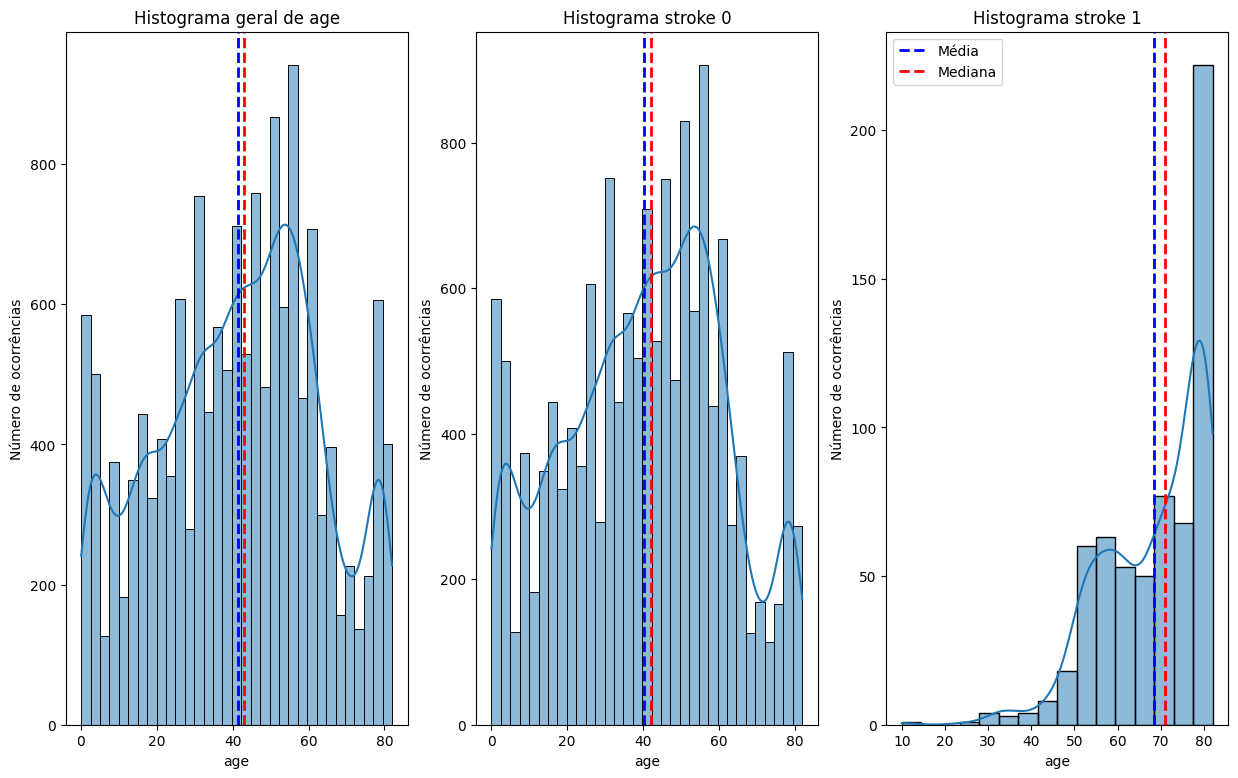

In [9]:
plot_histogramas(df, 'age')

O histograma da coluna idade, nos mostra que no geral, a distribuição de idade do dataset segue relativamente simétrica, bem como nos casos em que não houveram AVC. No caso em que o AVC aconteceu, a distribuição se torna assimétrica à direita, estando mais concentrado em idades mais altas.

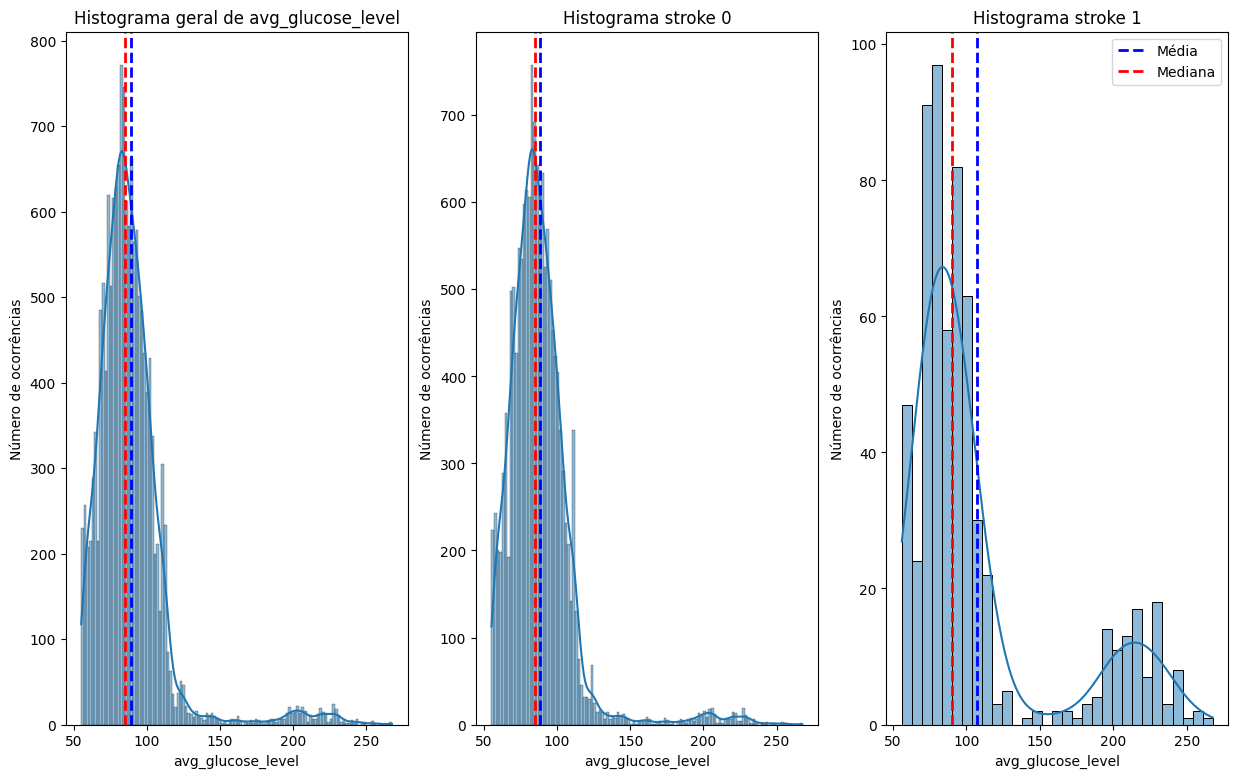

In [10]:
plot_histogramas(df, 'avg_glucose_level')

O histograma da coluna de glicose nos mostra que tanto no geral quanto em casos que não houveram AVCs, o nível se encontra assimétrico à esquerda, concentrado em valores mais baixos. Justifica-se estes valores quando consideramos que o nível médio saudável de glicose no corpo é de no máximo 99mg/dl, conforme citado. No caso em que houveram AVCs, há um valor médio maior que 100 e uma pequena distribuição nas maiores faixas, como 200-250.

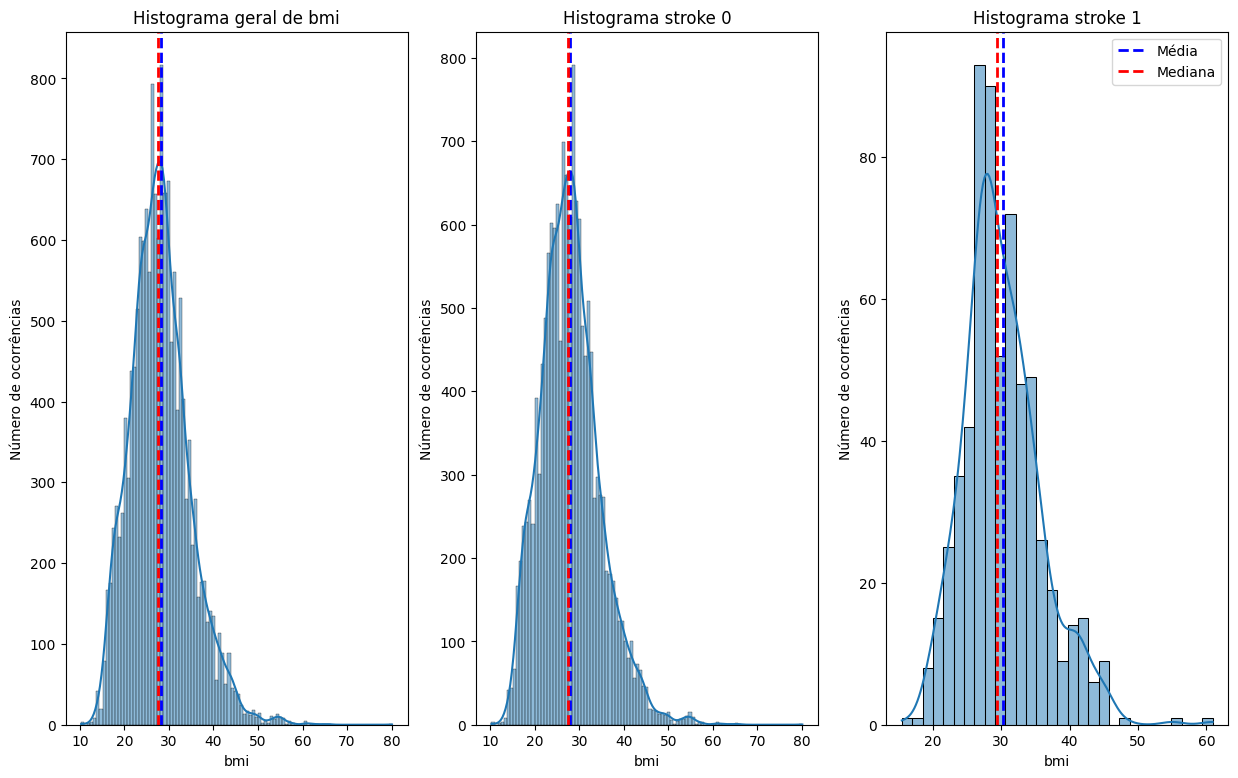

In [11]:
plot_histogramas(df, 'bmi')

No caso do (IMC) do paciente, temos distribuições parecidas em todos os casos, concentradas à esquerda. O valor médio fica bem próximo de 30 e até chega a passar nos casos em que houve um AVC.

## Analisando as colunas categóricas

In [12]:
def plot_categoricas(dataframe: pd.DataFrame, coluna: str) -> None:
    fig, ax = plt.subplots(nrows=1, ncols=3, figsize=(15,9))

    ax[0] = dataframe[coluna].value_counts(normalize=True).plot(xlabel=coluna, kind='bar', ax=ax[0]);
    ax[0].bar_label(ax[0].containers[0])
    ax[0].set_title(f'Frequência geral de {coluna}')
    ax[0].set_xlabel(coluna)
    ax[0].set_ylabel('Percentagem (decimal)');
    ax[0].set_ylim([0,1])
    
    ax[1] = dataframe[dataframe['stroke']==0][coluna].value_counts(normalize=True).plot(xlabel=coluna, kind='bar', ax=ax[1]);
    ax[1].bar_label(ax[1].containers[0])
    ax[1].set_title(f'Frequência stroke 0')
    ax[1].set_xlabel(coluna)
    ax[1].set_ylabel('Percentagem (decimal)');
    ax[1].set_ylim([0,1])
    
    ax[2] = dataframe[dataframe['stroke']==1][coluna].value_counts(normalize=True).plot(xlabel=coluna, kind='bar',ax=ax[2]);
    ax[2].bar_label(ax[2].containers[0])
    ax[2].set_title(f'Frequência stroke 1')
    ax[2].set_xlabel(coluna)
    ax[2].set_ylabel('Percentagem (decimal)');
    ax[2].set_ylim([0,1])
    
    plt.show();

### Frequência de cada gênero

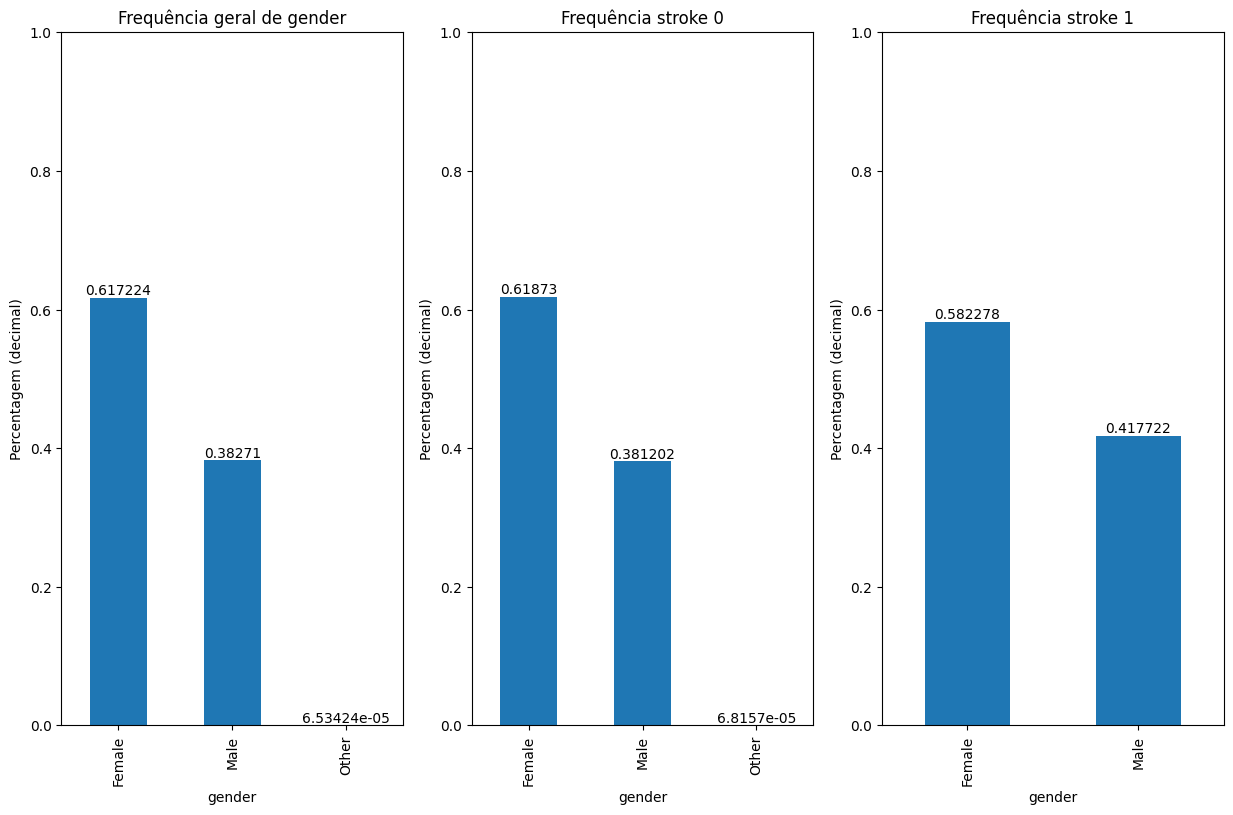

In [13]:
plot_categoricas(df, 'gender')

Podemos perceber que a proporção de Female e Male para ambas as classes (non stroke e stroke) são muito próximas, em que há mais mulheres do que homens no dataset.

Apenas uma pessoa aparece com gênero Other, sendo uma criança de 9 anos. Mais para frente, em tratamento do dataframe, excluiremos essa amostra do dataset.

In [14]:
df[df['gender']=='Other']

,id,gender,age,hypertension,heart_disease,ever_married,work_type,Residence_type,avg_glucose_level,bmi,smoking_status,stroke
9363,9363,Other,9.0,0,0,No,children,Rural,96.04,18.0,Unknown,0


### Frequência de ever_married

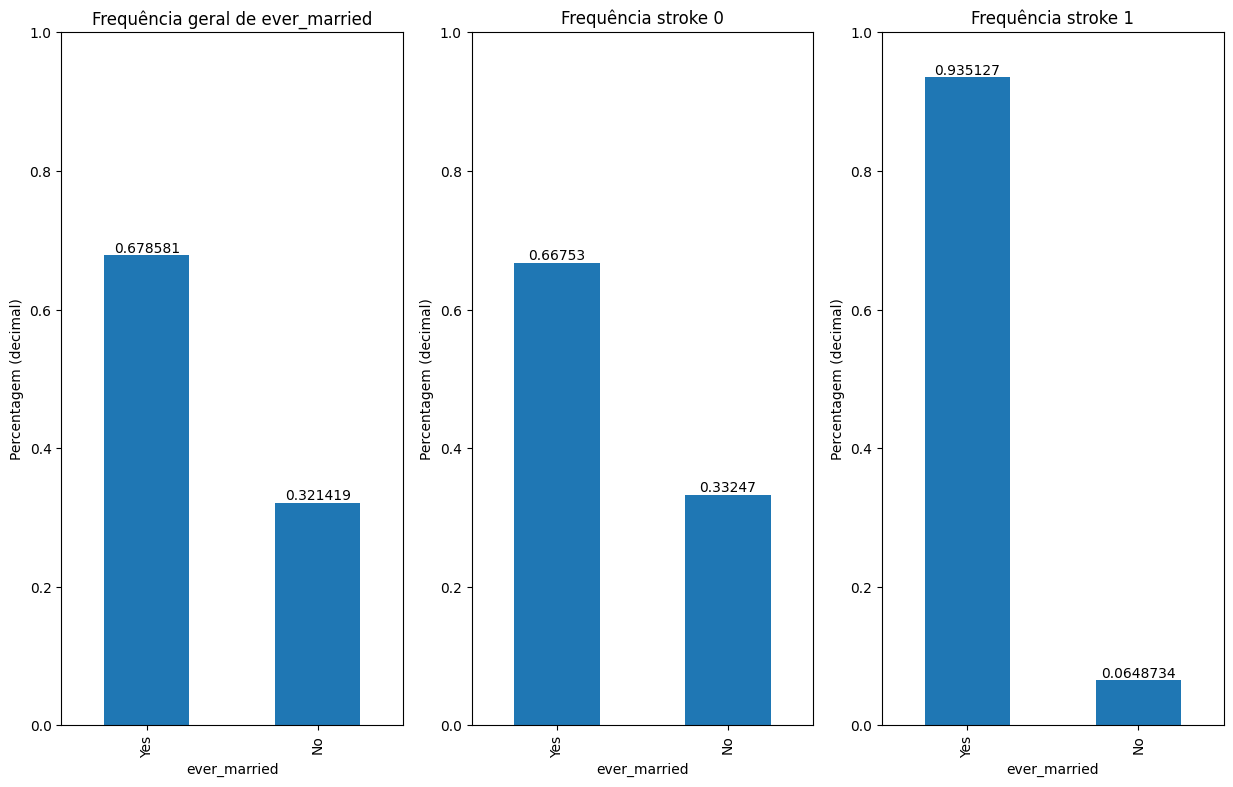

In [15]:
plot_categoricas(df, 'ever_married')

Para esta coluna podemos notar que a proporção de pessoas que já casaram e que não casaram permanece quase igual para o dataset em geral e para as pessoas que não tiveram stroke. Já para as que tiveram, mais de 93.5% já foram ou são casadas. Talvez por essas pessoas terem maior idade, então é mais fácil que em algum momento da vida  a maioria delas terem se casado, ou seria o casamento um fator estressante, que pode levar ao avc?

### Frequência de Residence_type

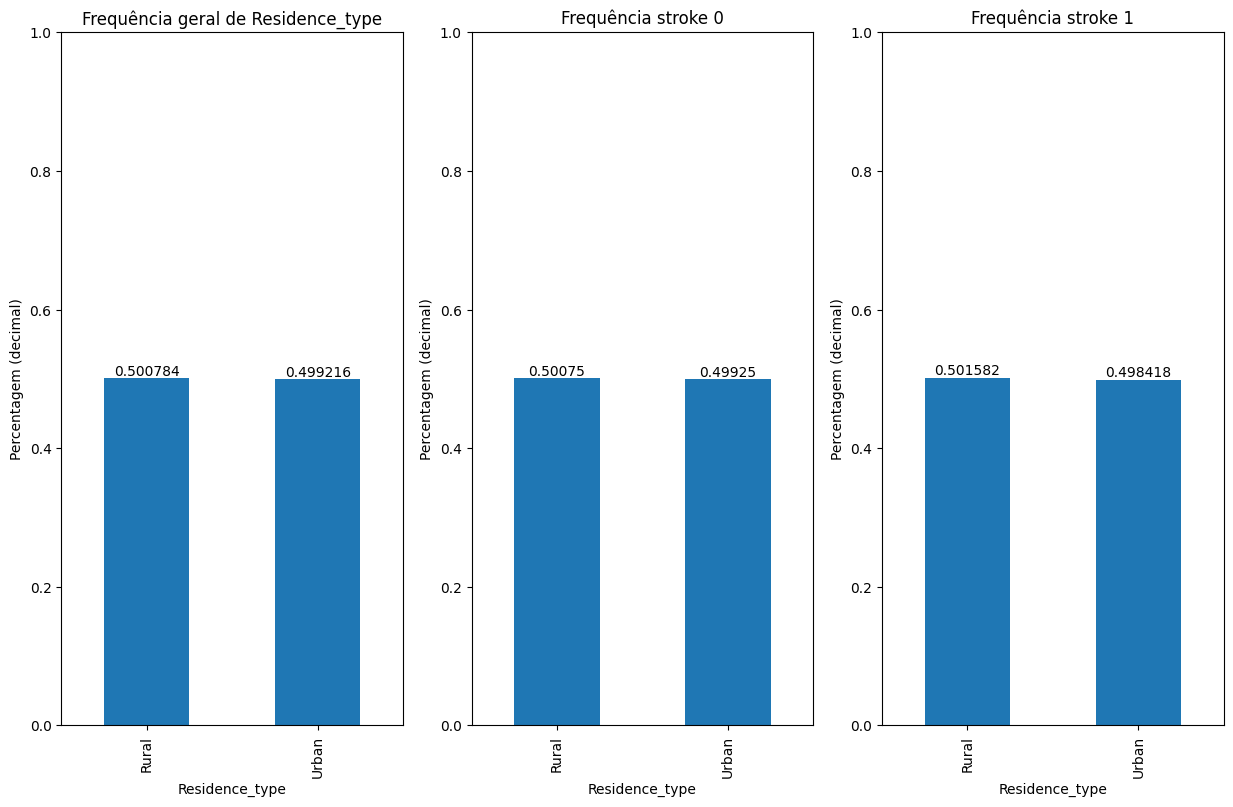

In [16]:
plot_categoricas(df, 'Residence_type')

Para esta coluna temos proporções muito parecidas, sendo quase perfeitamente distribuídas.

### Frequência de smoking_status

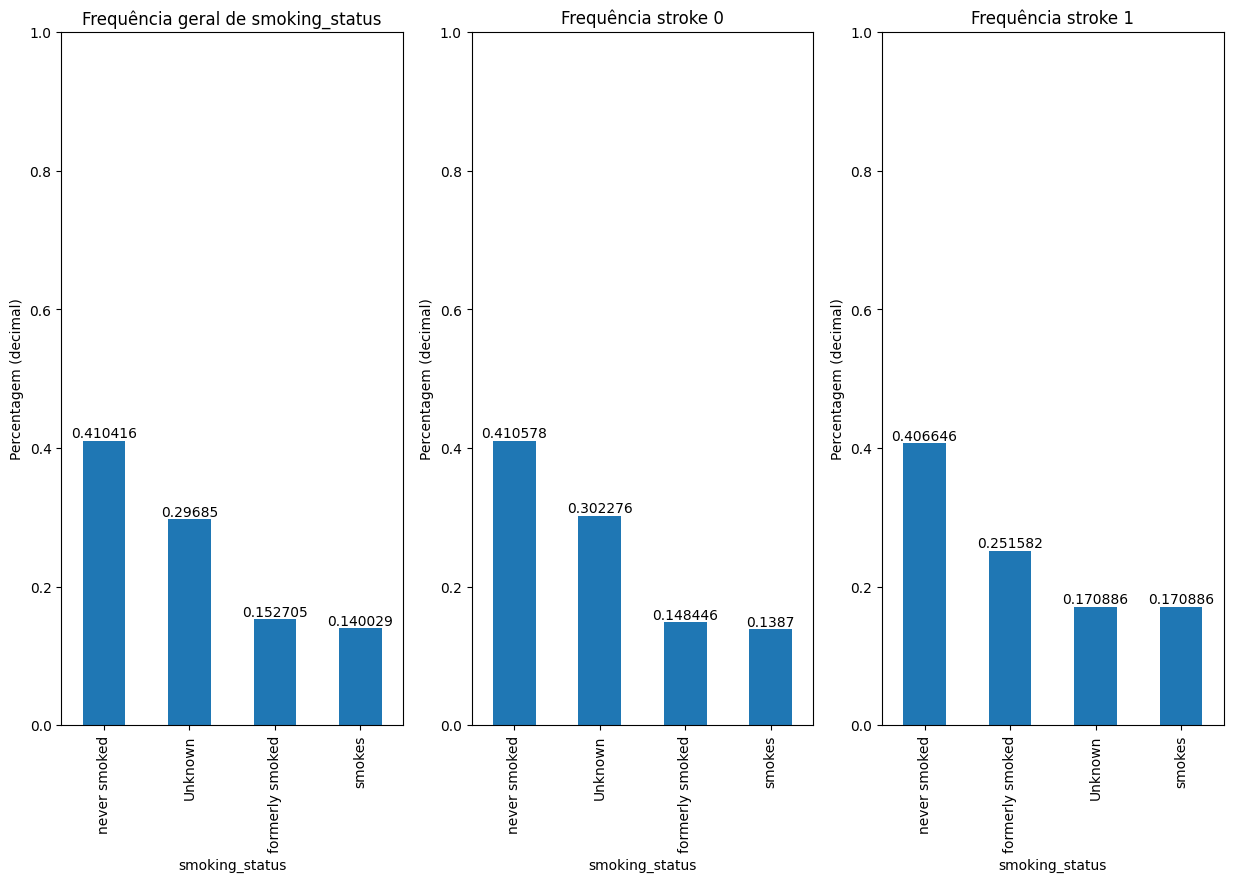

In [17]:
plot_categoricas(df, 'smoking_status')

Podemos notar que a proporção de pessoas que nunca fumaram se mantém em quase 41%, tanto para quem teve avc quanto para quem não teve. Já quem já fumou (formerly smoked) aparece em uma maior proporção para stroke 1, e também há uma maior proporção de fumantes (quase 4% a mais) nessa classe quando comparada com quem não teve avc. 

Os fumantes têm duas vezes mais chances de sofrer um avc e o tabagismo é relacionado em cerca de 20% dos casos de avc, uma vez que contribui para a acumulação de placas nas artérias, aumenta o risco de coágulos sanguíneos e reduz o oxigênio no sangue <sup>3,4</sup>.

<sup>3</sup> Fonte: [https://victorbarboza.com.br/por-que-o-cigarro-pode-causar-avc/](https://victorbarboza.com.br/por-que-o-cigarro-pode-causar-avc/)

<sup>4</sup> Fonte: [https://www.hcor.com.br/imprensa/noticias/cigarro-em-excesso-aumenta-o-risco-de-avc-e-cancer-de-pulmao/](https://www.hcor.com.br/imprensa/noticias/cigarro-em-excesso-aumenta-o-risco-de-avc-e-cancer-de-pulmao/)

### Frequência de hypertension

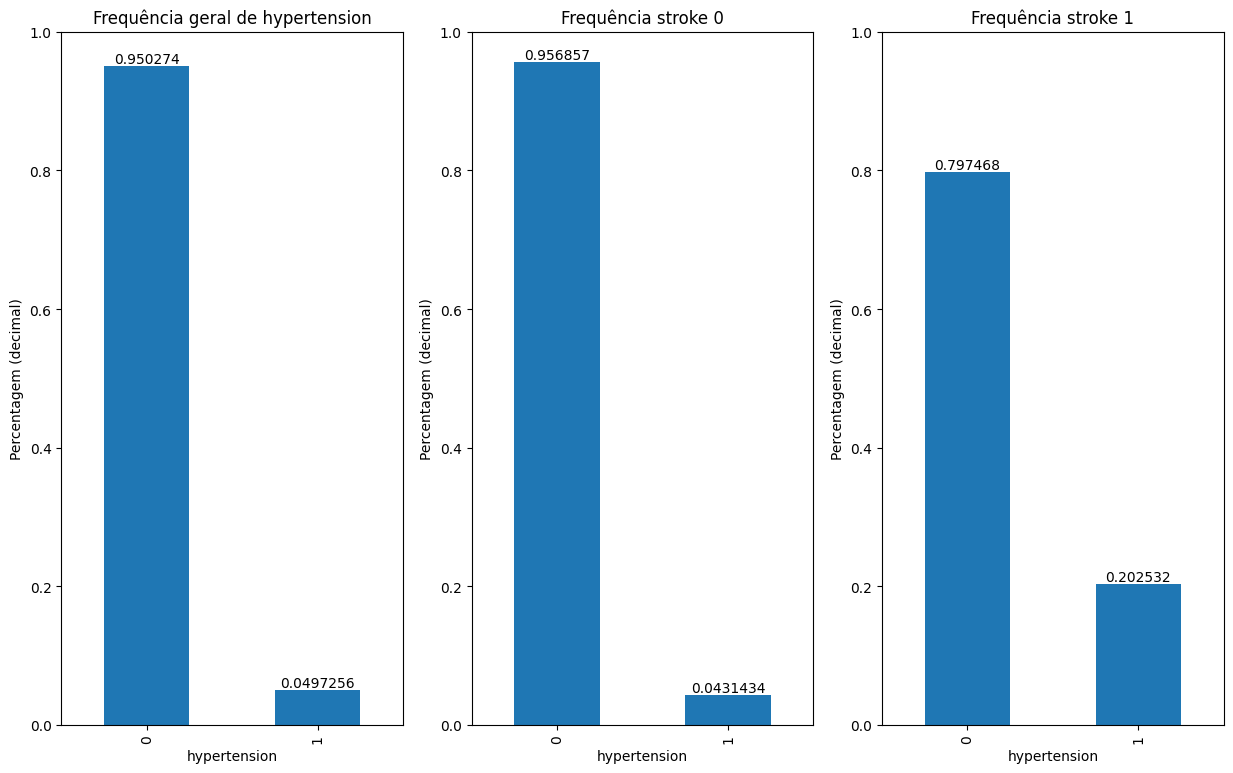

In [64]:
plot_categoricas(df,'hypertension')

Para esta coluna pode-se notar que a proporção de pessoas hipertensas se encontra majoritariamente concentrada nos casos 0 (sem hipertensão). Para aqueles que já tiveram um AVC, a proporção torna-se maior, um pouco maior que 20%.

### Frequência de heart_disease

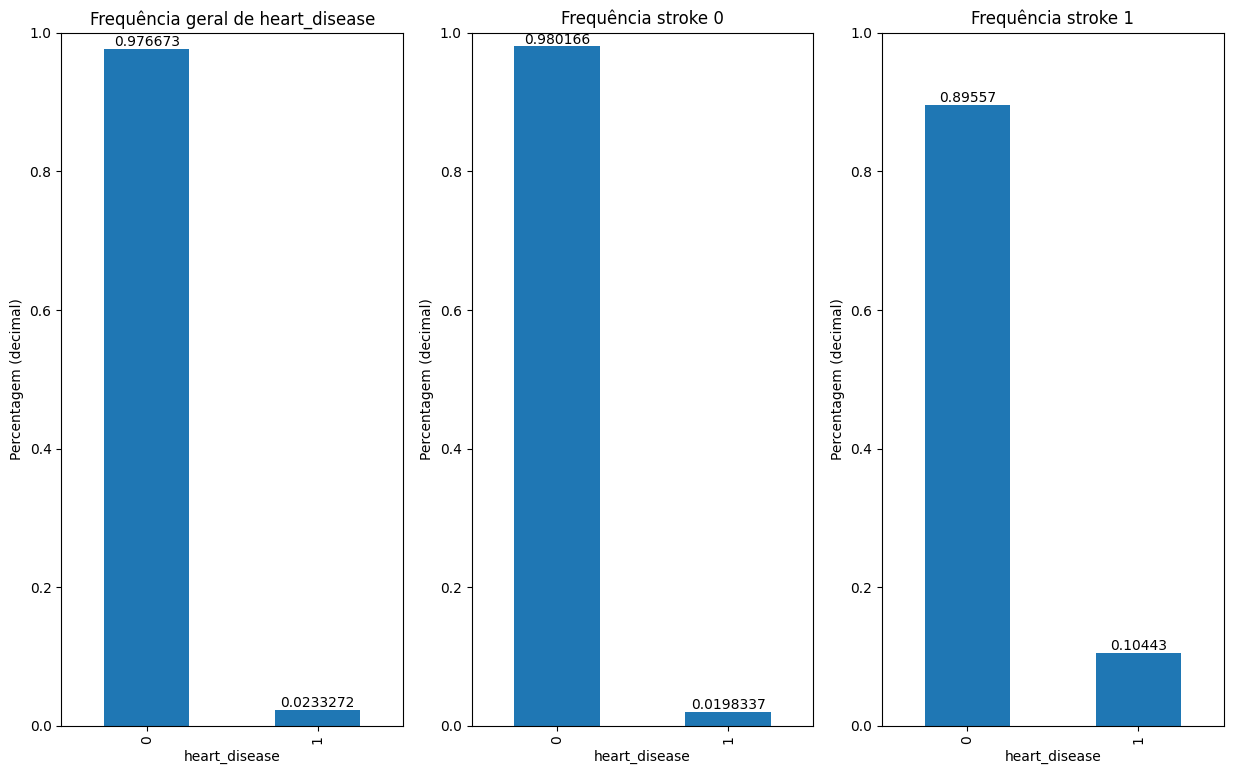

In [65]:
plot_categoricas(df,'heart_disease')

Para esta coluna pode-se notar que a proporção de pessoas que possuem alguma doença no coração se encontra majoritariamente concentrada nos casos 0 (sem doença). A proporção fica ainda menor nos casos que não tiveram avc e relativamente maior nos casos em que o avc aconteceu, atingindo a marca de 10%

### Quantidade de amostras para cada classe em stroke

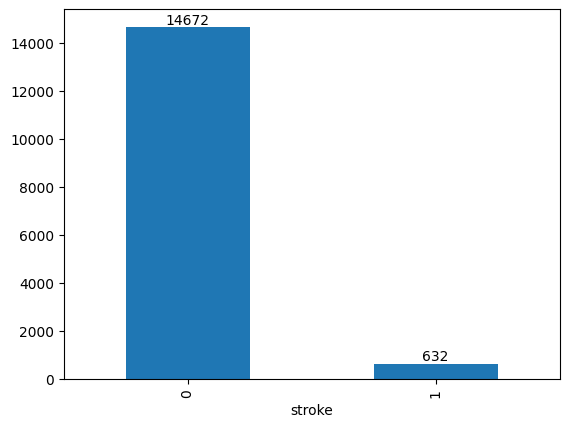

In [18]:
ax = df.stroke.value_counts().plot(xlabel='stroke', kind='bar');
ax.bar_label(ax.containers[0])
plt.show();

##### A partir do gráfico anterior observa-se um problema de desbalanceamento de amostras.

# Tratamento do DataFrame

Primeiramente foi excluída a amostra com gênero Other, por ser uma única.

Depois foi feita a transformação das features categóricas em numéricas, atribuindo valores binários. As colunas gender, ever_married e residence_type passaram a ter valores 0 (Male, No e Urban, respectivamente) e 1 (Female, Yes e Rural, respectivamente). 

Já a coluna work_type foi subdividida em colunas binárias para cada tipo de trabalho ('Private', 'Self-employed', 'Govt_job', 'children', 'Never_worked'). Isso foi feito para não dar algum tipo de hierarquia/peso aos tipos de trabalho. A coluna original, depois da criação dessas novas colunas, é excluída do dataframe.

Para a coluna smoking_status foram atribuídos os níveis de intensidade (0 para unknown, 1 never smoked, 2 para formely smoked e 3 para smokes).

In [19]:
df = df[df['gender']!='Other']

In [20]:
# Criando função para transformar features categóricas em numéricas
def get_dummy(dataframe: pd.DataFrame, column: str) -> pd.DataFrame:
    series = df[column]
    dummy  = pd.get_dummies(series)
    
    return dummy

In [21]:
#Aplicando função dummy para categoria work
df_work_dummy   = get_dummy(df,'work_type')

In [22]:
#gender = ['Male', 'Female']
df['gender'] = df['gender'].replace(['Male','Female'],[0,1])

#ever_married = ['Yes', 'No']
df['ever_married'] = df['ever_married'].replace(['No','Yes'],[0,1])

#Residence_type = ['Urban', 'Rural']
df['Residence_type'] = df['Residence_type'].replace(['Urban', 'Rural'],[0,1])

#smoking_status = ['never smoked', 'formerly smoked', 'Unknown', 'smokes']
df['smoking_status'] = df['smoking_status'].replace(['Unknown', 'never smoked', 'formerly smoked', 'smokes'], [0,1,2,3])

In [23]:
df

,id,gender,age,hypertension,heart_disease,ever_married,work_type,Residence_type,avg_glucose_level,bmi,smoking_status,stroke
0,0,0,28.0,0,0,1,Private,0,79.53,31.1,1,0
1,1,0,33.0,0,0,1,Private,1,78.44,23.9,2,0
2,2,1,42.0,0,0,1,Private,1,103.00,40.3,0,0
3,3,0,56.0,0,0,1,Private,0,64.87,28.8,1,0
4,4,1,24.0,0,0,0,Private,1,73.36,28.8,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...
15299,15299,1,22.0,0,0,0,Govt_job,0,72.63,19.5,1,0
15300,15300,1,46.0,1,0,1,Private,0,101.19,32.1,1,0
15301,15301,1,75.0,0,0,1,Self-employed,0,87.69,26.2,1,0
15302,15302,0,46.0,0,0,1,Private,1,101.13,22.5,0,0


In [24]:
# Concatenando valores para o novo datafarme
df_processed = pd.concat([df,df_work_dummy],axis=1)
df_processed.drop(columns='work_type',inplace=True)
df_processed.info()

<class 'pandas.core.frame.DataFrame'>
Index: 15303 entries, 0 to 15303
Data columns (total 16 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   id                 15303 non-null  int64  
 1   gender             15303 non-null  int64  
 2   age                15303 non-null  float64
 3   hypertension       15303 non-null  int64  
 4   heart_disease      15303 non-null  int64  
 5   ever_married       15303 non-null  int64  
 6   Residence_type     15303 non-null  int64  
 7   avg_glucose_level  15303 non-null  float64
 8   bmi                15303 non-null  float64
 9   smoking_status     15303 non-null  int64  
 10  stroke             15303 non-null  int64  
 11  Govt_job           15303 non-null  bool   
 12  Never_worked       15303 non-null  bool   
 13  Private            15303 non-null  bool   
 14  Self-employed      15303 non-null  bool   
 15  children           15303 non-null  bool   
dtypes: bool(5), float64(3), int

In [25]:
df_processed

,id,gender,age,hypertension,heart_disease,ever_married,Residence_type,avg_glucose_level,bmi,smoking_status,stroke,Govt_job,Never_worked,Private,Self-employed,children
0,0,0,28.0,0,0,1,0,79.53,31.1,1,0,False,False,True,False,False
1,1,0,33.0,0,0,1,1,78.44,23.9,2,0,False,False,True,False,False
2,2,1,42.0,0,0,1,1,103.00,40.3,0,0,False,False,True,False,False
3,3,0,56.0,0,0,1,0,64.87,28.8,1,0,False,False,True,False,False
4,4,1,24.0,0,0,0,1,73.36,28.8,1,0,False,False,True,False,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
15299,15299,1,22.0,0,0,0,0,72.63,19.5,1,0,True,False,False,False,False
15300,15300,1,46.0,1,0,1,0,101.19,32.1,1,0,False,False,True,False,False
15301,15301,1,75.0,0,0,1,0,87.69,26.2,1,0,False,False,False,True,False
15302,15302,0,46.0,0,0,1,1,101.13,22.5,0,0,False,False,True,False,False


# Análise estatística e seleção de Features

##### Para tentar maximizar o aprendizado do modelo, primeiramente fizemos um teste de correlação de variáveis para poder selecionar melhor as features a serem utilizadas nos modelos.


In [26]:
# Definindo função para computar correlação entre as variáveis e plotar como heatmap
def correlation_analysis(df):
    
    correlation_matrix = df.corr(numeric_only=True)
    plt.figure(figsize=(16, 8))
    sns.heatmap(correlation_matrix, annot=True, cmap="coolwarm")
    plt.title("Matriz de Correlação")
    plt.show()
    
    return(correlation_matrix) 

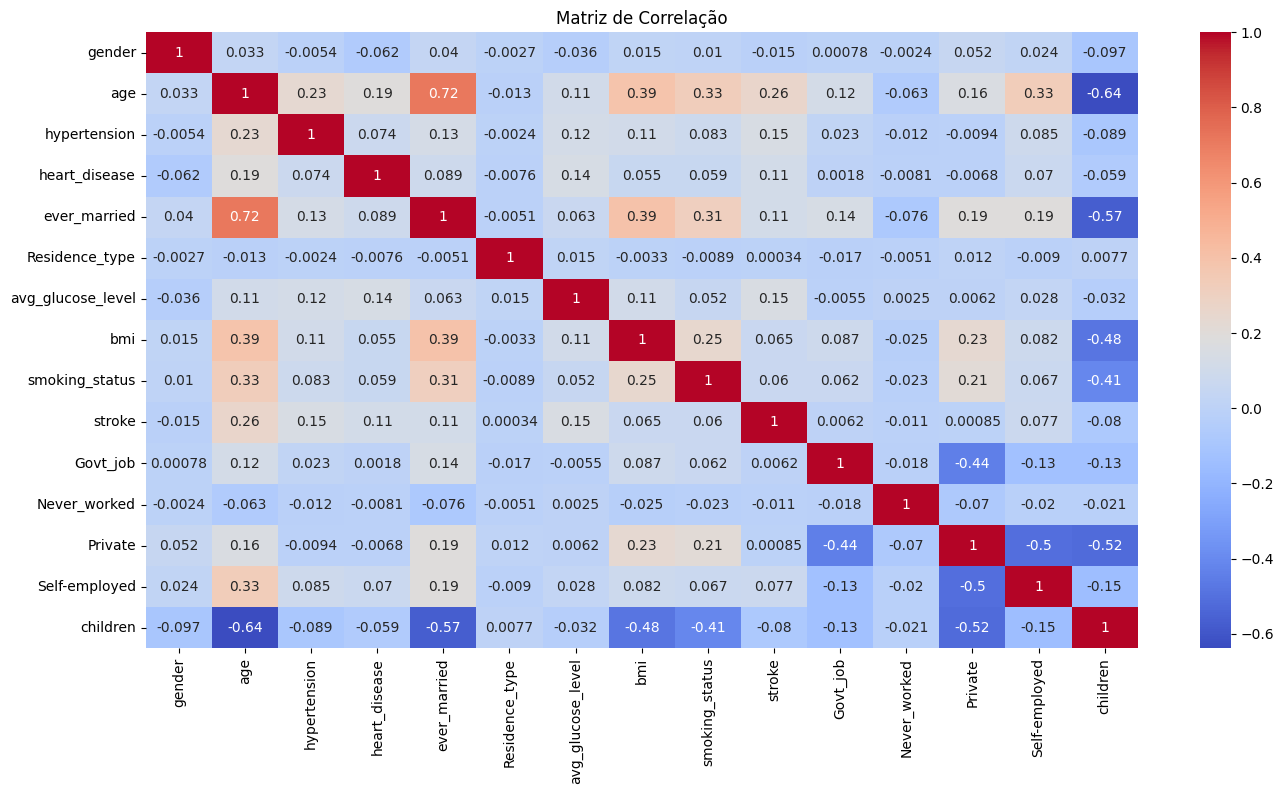

,gender,age,hypertension,heart_disease,ever_married,Residence_type,avg_glucose_level,bmi,smoking_status,stroke,Govt_job,Never_worked,Private,Self-employed,children
gender,1.000000,0.032896,-0.005404,-0.061780,0.039644,-0.002715,-0.035529,0.015317,0.010192,-0.014940,0.000776,-0.002377,0.051574,0.023896,-0.096715
age,0.032896,1.000000,0.232624,0.193394,0.716924,-0.013171,0.108933,0.390630,0.327354,0.261319,0.119574,-0.062535,0.156003,0.328593,-0.638627
hypertension,-0.005404,0.232624,1.000000,0.074176,0.128458,-0.002448,0.122838,0.106651,0.083491,0.145892,0.022794,-0.012001,-0.009351,0.085466,-0.088756
heart_disease,-0.061780,0.193394,0.074176,1.000000,0.088743,-0.007592,0.137151,0.054571,0.058900,0.111516,0.001784,-0.008108,-0.006755,0.069972,-0.059287
ever_married,0.039644,0.716924,0.128458,0.088743,1.000000,-0.005123,0.063019,0.394585,0.311284,0.113998,0.140129,-0.076233,0.192389,0.188092,-0.568599
Residence_type,-0.002715,-0.013171,-0.002448,-0.007592,-0.005123,1.000000,0.015034,-0.003306,-0.008935,0.000345,-0.017261,-0.005075,0.012143,-0.009020,0.007683
avg_glucose_level,-0.035529,0.108933,0.122838,0.137151,0.063019,0.015034,1.000000,0.108177,0.052166,0.149278,-0.005456,0.002466,0.006208,0.028386,-0.032141
bmi,0.015317,0.390630,0.106651,0.054571,0.394585,-0.003306,0.108177,1.000000,0.250858,0.065377,0.087409,-0.024596,0.232501,0.082282,-0.483114
smoking_status,0.010192,0.327354,0.083491,0.058900,0.311284,-0.008935,0.052166,0.250858,1.000000,0.059724,0.062204,-0.023475,0.207899,0.067152,-0.411372
stroke,-0.014940,0.261319,0.145892,0.111516,0.113998,0.000345,0.149278,0.065377,0.059724,1.000000,0.006222,-0.010888,0.000855,0.076928,-0.080364


In [27]:
# Computando correlação para o dataset corrigido

correlation_analysis(df_processed.drop(columns='id'))

##### Apesar de termos gerado uma matriz de correlação. A correlação de Pearson não é a métrica mais adequada para avaliar a correlação de variáveis binárias dicotômicas. Dessa forma, iremos realizar o teste de Qui-quadrado para avaliar se as features binárias são correlacionadas. O importante do cálculo anterior é: As variáveis contínuas não são correlacionadas. O teste do chi-quadrado tem a hipótese nula que as duas variáveis (nesse caso binárias) não tem correlação entre si. Caso passe no teste para determinado nível de significância, terá como saída TRUE.

In [28]:
'''
Assumption(H0): The two columns are NOT related to each other
Result of Chi-Sq Test: The Probability of H0 being True
'''


def chi_square_test(df, significance_level):
    def perform_chi_square_test(col1, col2):
        cross_tab = pd.crosstab(df[col1], df[col2])
        chi_sq_result = chi2_contingency(cross_tab)
        p_value = chi_sq_result[1]
        return 0 if p_value < significance_level else 1
 
    binary_columns = df.select_dtypes(include=['int64','bool', 'uint8']).columns
    result_matrix = pd.DataFrame(index=binary_columns, columns=binary_columns)

    for col1 in binary_columns:
        for col2 in binary_columns:
            result_matrix.at[col1, col2] = perform_chi_square_test(col1, col2)

    return result_matrix

In [29]:
binary_correlation_matrix = chi_square_test(df_processed.drop(columns=['id','stroke','smoking_status']),0.05)
binary_correlation_matrix

,gender,hypertension,heart_disease,ever_married,Residence_type,Govt_job,Never_worked,Private,Self-employed,children
gender,0,1,0,0,1,1,1,0,0,0
hypertension,1,0,0,0,1,0,1,1,0,0
heart_disease,0,0,0,0,1,1,1,1,0,0
ever_married,0,0,0,0,1,0,0,0,0,0
Residence_type,1,1,1,1,0,0,1,1,1,1
Govt_job,1,0,1,0,0,0,1,0,0,0
Never_worked,1,1,1,0,1,1,0,0,0,0
Private,0,1,1,0,1,0,0,0,0,0
Self-employed,0,0,0,0,1,0,0,0,0,0
children,0,0,0,0,1,0,0,0,0,0


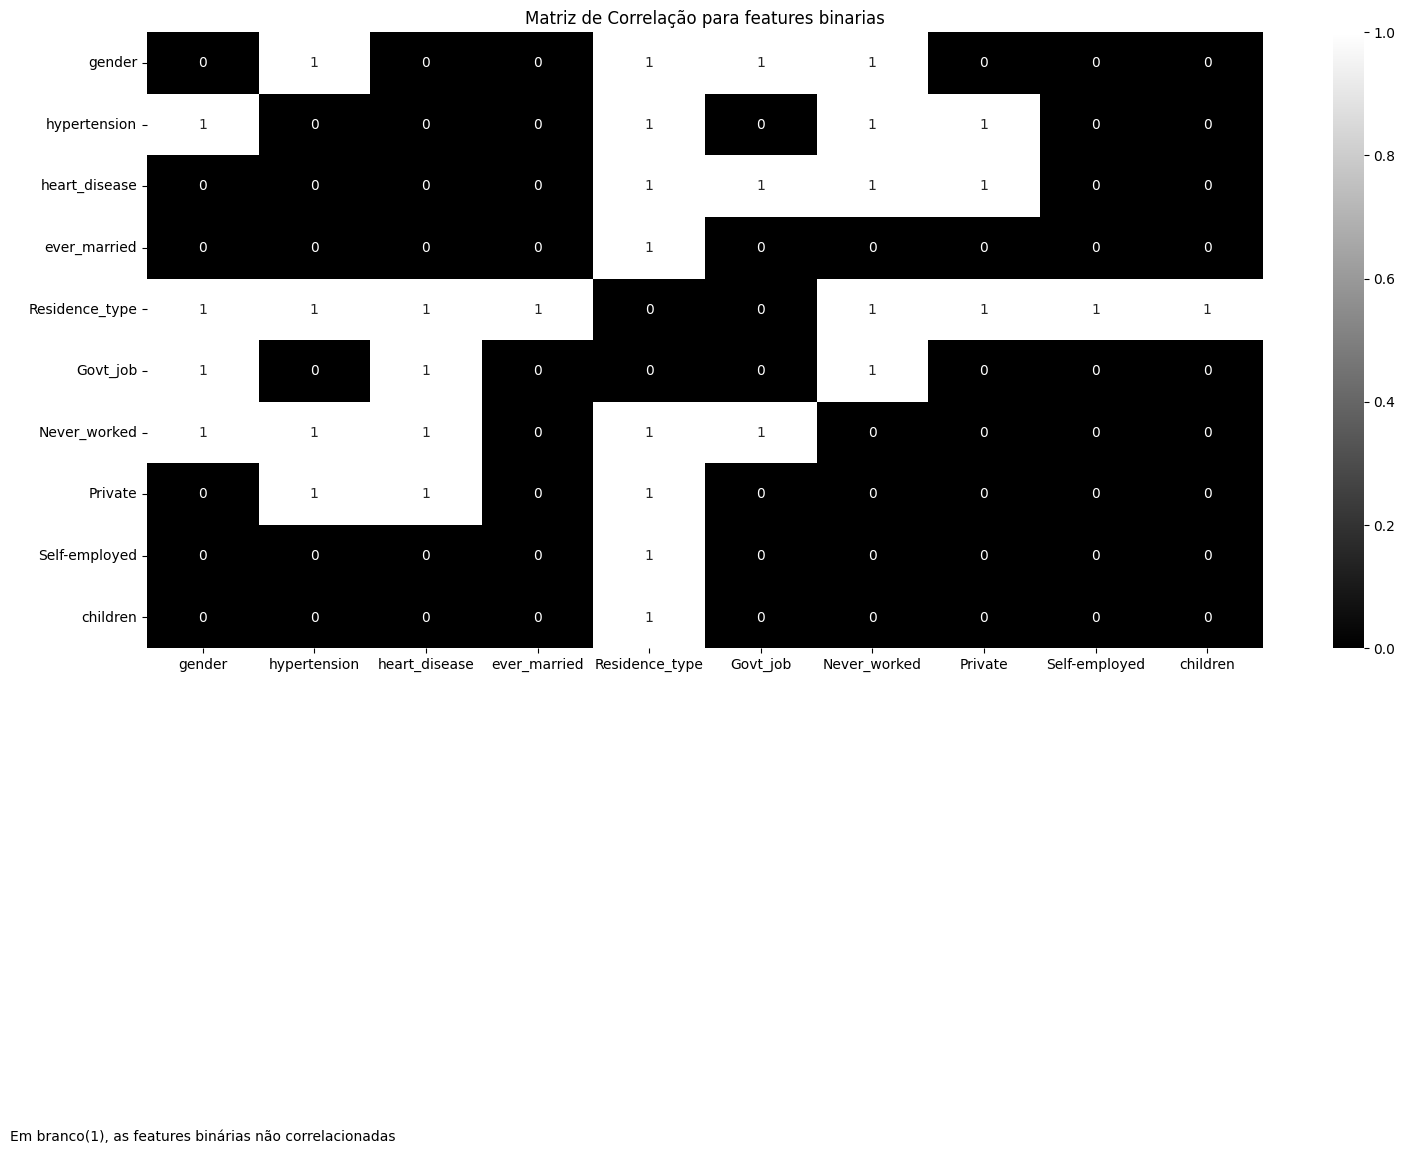

In [30]:
plt.figure(figsize=(18, 8))
sns.heatmap(binary_correlation_matrix.astype(float), annot=True, cmap='gist_gray')
plt.title("Matriz de Correlação para features binarias")
plt.text(0.5, 18, "Em branco(1), as features binárias não correlacionadas", fontsize=10, ha="center")
plt.show()


In [31]:
sum_of_non_correlated_features = chi_square_test(df_processed.drop(columns=['id','stroke','smoking_status']),0.05).sum()
sum_of_non_correlated_features.sort_values(ascending=False)

Residence_type    8
Never_worked      5
gender            4
hypertension      4
heart_disease     4
Govt_job          3
Private           3
ever_married      1
Self-employed     1
children          1
dtype: object

### Ranking de Importância de features baseada em diminuição média de impureza

##### Uma forma de tentar selecionar as melhores features para o nosso modelo é gerar o índice de Gini a partir de um modelo de árvores de decisão. Para isto, escolhemos o classificador Extra-Trees para gerar, a partir de 100 árvores aleatórias, as métricas de impureza para as features do nosso dataframe.

In [32]:
# Removendo do dataset as colunas id e stroke

columns = list(df_processed.columns)
columns.remove('id')
columns.remove('stroke')

X = df_processed[columns].to_numpy()
y = df_processed['stroke'].to_numpy()


In [33]:
features_names = columns
skf_processed = StratifiedKFold(n_splits=10, random_state=99, shuffle=True)
random_states = [36, 47, 15, 29, 132, 85, 2, 96, 10, 194]
clfs           = []
for i, (train_index, test_index) in enumerate(skf_processed.split(X, y)):
    X_train_fold = X[train_index]
    y_train_fold = y[train_index]
    X_test_fold  = X[test_index]
    y_test_fold  = y[test_index]
    
    clf = ExtraTreesClassifier(n_estimators=100, random_state = random_states[i])
    clf = clf.fit(X_train_fold, y_train_fold)

    clfs.append(clf)

In [34]:
forest_imp = pd.Series(np.zeros(len(columns)),index=columns)
std = np.zeros(len(columns)) 
for _clf in clfs:
    forest_imp += pd.Series(_clf.feature_importances_, index=columns)
    std += np.std([tree.feature_importances_ for tree in _clf.estimators_ ], axis=0) 
media_forest_imp = forest_imp/len(clfs)
media_std        = std/len(clfs)

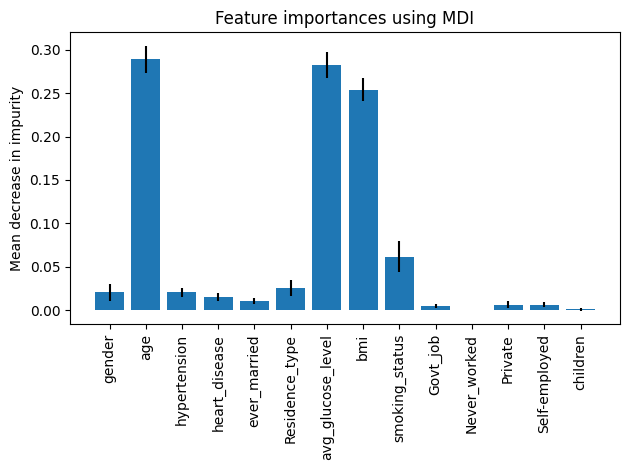

In [35]:
fig, ax = plt.subplots()
plt.bar(np.arange(len(columns)),media_forest_imp,yerr=media_std, align='center')
ax.set_title("Feature importances using MDI")
ax.set_ylabel("Mean decrease in impurity")
ax.set_xticks(np.arange(len(columns)))
ax.set_xticklabels(columns)
plt.xticks(rotation=90)
fig.tight_layout()

In [36]:
media_forest_imp.sort_values(ascending=False)

age                  0.288838
avg_glucose_level    0.282549
bmi                  0.253993
smoking_status       0.061820
Residence_type       0.025802
hypertension         0.020702
gender               0.020665
heart_disease        0.015164
ever_married         0.011139
Self-employed        0.006652
Private              0.006522
Govt_job             0.004963
children             0.001179
Never_worked         0.000013
dtype: float64

##### Vamos selecionar as 5 features com melhor índice de Gini

In [37]:
selected_row_names_gini = media_forest_imp.sort_values(ascending=False)[0:5].index
selected_row_names_gini

Index(['age', 'avg_glucose_level', 'bmi', 'smoking_status', 'Residence_type'], dtype='object')

##### Em relação as features binárias, vamos reselecionar as features que não tem correlação com a feature binária Residence_type

In [38]:
binary_correlation_matrix[binary_correlation_matrix['Residence_type'] == 1]['Residence_type']
selected_row_names_corr = binary_correlation_matrix[binary_correlation_matrix['Residence_type'] == 1]['Residence_type'].index
selected_row_names_corr

Index(['gender', 'hypertension', 'heart_disease', 'ever_married',
       'Never_worked', 'Private', 'Self-employed', 'children'],
      dtype='object')

In [39]:
# juntando as listas de feições para classificação

#selected_features = list(selected_row_names_corr) + list(selected_row_names_gini) # Testamos várias features, 
#porém não conseguimos resultados satisfatórios
selected_features = list(selected_row_names_gini)
selected_features 

['age', 'avg_glucose_level', 'bmi', 'smoking_status', 'Residence_type']

### Classificações sem balanceamento de amostras

In [40]:
columns = list(df_processed.columns)

df_processed.drop_duplicates(subset=columns, inplace=True)

columns.remove('id')
columns.remove('stroke')

X = df_processed[columns].to_numpy()
y = df_processed['stroke'].to_numpy()

precisions = []
recalls    = []
aucs       = []
for i, (train_index, test_index) in enumerate(skf_processed.split(X, y)):
    X_train_fold = X[train_index]
    y_train_fold = y[train_index]
    X_test_fold  = X[test_index]
    y_test_fold  = y[test_index]
    
    RF = RandomForestClassifier(class_weight = 'balanced_subsample', random_state=random_states[i])
    RF.fit(X_train_fold, y_train_fold)
    
    y_pred = RF.predict(X_test_fold)
    
    precision, recall, _ = roc_curve(y_test_fold, y_pred)
    auc_score = auc(recall, precision)
    
    precisions.append(precision)
    recalls.append(recall)
    aucs.append(auc_score)
    
print('Médias ')
print(f'Precision: {np.mean(precisions)}')
print(f'Recall: {np.mean(recalls)}')
print(f'AUC: {np.mean(aucs)}')
print('Desvios ')
print(f'Precision: {np.std(precisions)}')
print(f'Recall: {np.std(recalls)}')
print(f'AUC: {np.std(aucs)}')

Médias 
Precision: 0.3340831164826919
Recall: 0.3423115079365079
AUC: 0.48765741281927594
Desvios 
Precision: 0.4708755042768914
Recall: 0.4653316806498327
AUC: 0.010174572052048551


# Amostragem

##### Para amostragem, foi decidido realizar uma amostragem aleatória estratificada pelas proporções da classe 'stroke'. Dessa forma, como existe poucos valores de 'stroke' no daframe, decidimos separar as amostras em 0.8 para treinamento e 0.2 para teste/validação dos modelos.

##### Como vimos que o modelo está desbalanceado. Utilizamos a técnida de downsampling da classe que possui mais amostras ('non_stroke'). Dessa forma, selecionamos de forma aleatória e reprodutível, um número de amostras para classe 'non_stroke' que é exatamente a quantidade de amostras que temos no dataframe para stroke.

In [41]:
# Reamostrando a classe com mais amostras (downsampling)
not_stroke = df_processed[df_processed['stroke']==0]
stroke     = df_processed[df_processed['stroke']==1]
not_stroke_downsampled = resample(not_stroke,
                                replace = False, # sample without replacement
                                n_samples = len(stroke), # match minority n
                                random_state = 27)
print(not_stroke_downsampled.shape)

downsampled = pd.concat([not_stroke_downsampled, stroke])

(632, 16)


In [42]:
downsampled

,id,gender,age,hypertension,heart_disease,ever_married,Residence_type,avg_glucose_level,bmi,smoking_status,stroke,Govt_job,Never_worked,Private,Self-employed,children
6091,6091,1,39.00,0,0,1,0,82.85,41.7,0,0,True,False,False,False,False
2751,2751,0,5.00,0,0,0,1,80.84,16.6,0,0,False,False,False,False,True
13785,13785,1,1.64,0,0,0,1,170.88,17.3,0,0,False,False,False,False,True
9156,9156,1,51.00,0,0,1,0,111.92,27.7,0,0,False,False,False,True,False
10112,10112,0,56.00,0,0,1,1,82.37,35.6,2,0,False,False,True,False,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
15225,15225,1,76.00,0,1,1,1,60.98,29.1,1,1,False,False,True,False,False
15246,15246,0,81.00,0,0,1,1,95.84,23.4,0,1,False,False,False,True,False
15250,15250,0,67.00,0,0,1,1,98.39,44.1,2,1,False,False,False,True,False
15275,15275,1,69.00,0,0,1,0,99.10,22.7,2,1,False,False,True,False,False


# Classificações

#### Foram escolhidos três classificadores distintos para o projeto, levando em consideração três critérios: serem classificadores de escopo diferente, não fazerem suposições explícitas sobre a distribuição dos dados e serem adequados a classificações Binárias. Assim, escolhemos os classificadores:

##### > Regressão Logística (modelo de classificação linear);
##### > Random Forest (modelo de classificação por árvores de decisão);
##### > Multiple layer perceptron (modelo de classificação linear por redes neurais);

### Análise de parâmetros dos classificadores

In [43]:
pipelines = {
    'Random Forest': Pipeline([
        ('classifier', RandomForestClassifier(random_state=15))
    ]),
    'MLP Classifier': Pipeline([
        ('classifier', MLPClassifier(random_state=1, max_iter=1000))
    ]),
    'Logistic Regression': Pipeline([
        ('classifier', LogisticRegression(random_state=0, max_iter=2000))
    ]),
}

In [44]:
param_grid = {
    'Random Forest':{
        'classifier__n_estimators': np.arange(100,550,50),
        'classifier__max_depth': [2,4,6],
        'classifier__criterion': ['gini','entropy']
    },
    'Logistic Regression':{
        'classifier__solver': ['lbfgs', 'liblinear']
    },
    'MLP Classifier':{
        'classifier__hidden_layer_sizes': [(100,),(300,),(500,),(700,)],
        'classifier__learning_rate_init': [0.1, 0.01, 0.001, 0.0001],
        'classifier__activation': ['logistic','relu']
    }
}

In [45]:
X = downsampled[selected_features]
y = downsampled['stroke']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state = 42, stratify = y, shuffle=True)

scaler = MinMaxScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled  = scaler.transform(X_test)

In [46]:
list_best_params = []
for model_name, pipeline in pipelines.items():
    
    grid_search = GridSearchCV(pipeline, param_grid[model_name], scoring='recall')
    
    if model_name == 'Logistic Regression' or model_name == "MLP Classifier":
        grid_search.fit(X_train_scaled, y_train)
    else:
        grid_search.fit(X_train, y_train)
    
    best_params = grid_search.best_params_
    list_best_params.append(best_params)
    best_model = grid_search.best_estimator_
    
    if model_name == 'Logistic Regression' or model_name == "MLP Classifier":
        y_pred = best_model.predict(X_test_scaled)
    else:
        y_pred = best_model.predict(X_test)
        
    recall = recall_score(y_test, y_pred)
    precision = precision_score(y_test,y_pred)    
    
    print("Modelo: ", model_name)
    print("Melhores Parâmetros: ", best_params)
    print("Recall: ", recall)
    print("Precision: ", precision)

Modelo:  Random Forest
Melhores Parâmetros:  {'classifier__criterion': 'entropy', 'classifier__max_depth': 2, 'classifier__n_estimators': 250}
Recall:  0.9206349206349206
Precision:  0.7682119205298014


c:\Users\INTEL\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  warnings.warn(
c:\Users\INTEL\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  warnings.warn(
c:\Users\INTEL\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  warnings.warn(
c:\Users\INTEL\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the 

Modelo:  MLP Classifier
Melhores Parâmetros:  {'classifier__activation': 'logistic', 'classifier__hidden_layer_sizes': (500,), 'classifier__learning_rate_init': 0.1}
Recall:  0.9126984126984127
Precision:  0.7516339869281046
Modelo:  Logistic Regression
Melhores Parâmetros:  {'classifier__solver': 'lbfgs'}
Recall:  0.7777777777777778
Precision:  0.8032786885245902


### Classificações com balanceamento de amostras

In [47]:
downsampled = pd.concat([not_stroke_downsampled, stroke])
downsampled

,id,gender,age,hypertension,heart_disease,ever_married,Residence_type,avg_glucose_level,bmi,smoking_status,stroke,Govt_job,Never_worked,Private,Self-employed,children
6091,6091,1,39.00,0,0,1,0,82.85,41.7,0,0,True,False,False,False,False
2751,2751,0,5.00,0,0,0,1,80.84,16.6,0,0,False,False,False,False,True
13785,13785,1,1.64,0,0,0,1,170.88,17.3,0,0,False,False,False,False,True
9156,9156,1,51.00,0,0,1,0,111.92,27.7,0,0,False,False,False,True,False
10112,10112,0,56.00,0,0,1,1,82.37,35.6,2,0,False,False,True,False,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
15225,15225,1,76.00,0,1,1,1,60.98,29.1,1,1,False,False,True,False,False
15246,15246,0,81.00,0,0,1,1,95.84,23.4,0,1,False,False,False,True,False
15250,15250,0,67.00,0,0,1,1,98.39,44.1,2,1,False,False,False,True,False
15275,15275,1,69.00,0,0,1,0,99.10,22.7,2,1,False,False,True,False,False


In [48]:
X = downsampled[selected_features]
y = downsampled['stroke']
target_names = ['non_stroke', 'stroke']

print(X.shape)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state = 42, stratify = y, shuffle=True)

(1264, 5)


##### Random Forest

In [49]:
#Melhores Parâmetros:  {'classifier__criterion': 'entropy', 'classifier__max_depth': 2, 
#    'classifier__n_estimators': 250}

RF = RandomForestClassifier(random_state=15, criterion='entropy', max_depth=2, n_estimators=250)

RF.fit(X_train, y_train)

y_pred_rf = RF.predict(X_test)

CR = classification_report(y_test, y_pred_rf,target_names=target_names)

print(CR)

precision, recall, _ = roc_curve(y_test, y_pred_rf)
auc_score_rf = auc(precision, recall)


prf= precision_recall_fscore_support(y_test, y_pred_rf, average = 'binary', beta=2)
recall_rf = prf[1]
f1_score_rf = prf[2]
mcc_rf = matthews_corrcoef(y_test, y_pred_rf)

print('pr modelo: ', auc_score_rf) 

              precision    recall  f1-score   support

  non_stroke       0.90      0.72      0.80       127
      stroke       0.77      0.92      0.84       126

    accuracy                           0.82       253
   macro avg       0.84      0.82      0.82       253
weighted avg       0.84      0.82      0.82       253

pr modelo:  0.8225221847269092


In [50]:
print(recall_rf, f1_score_rf, mcc_rf, auc_score_rf)

0.9206349206349206 0.8854961832061068 0.6574885016644417 0.8225221847269092


##### Regressão Logística

In [51]:
scaler = MinMaxScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled  = scaler.transform(X_test)

In [52]:
#Melhores Parâmetros:  {'classifier__solver': 'lbfgs'}

LR     = LogisticRegression(random_state=0, max_iter=2000, solver='lbfgs').fit(X_train_scaled, y_train)
y_pred_lr = LR.predict(X_test_scaled)

CR = classification_report(y_test, y_pred_lr,target_names=target_names)

print(CR)

precision, recall, _ = roc_curve(y_test, y_pred_lr)
auc_score_lr = auc(precision, recall)


prf= precision_recall_fscore_support(y_test, y_pred_lr, average = 'binary', beta=2)
recall_lr = prf[1]
f1_score_lr = prf[2]
mcc_lr = matthews_corrcoef(y_test, y_pred_lr)

print('pr modelo: ', auc_score_lr) 

              precision    recall  f1-score   support

  non_stroke       0.79      0.81      0.80       127
      stroke       0.80      0.78      0.79       126

    accuracy                           0.79       253
   macro avg       0.79      0.79      0.79       253
weighted avg       0.79      0.79      0.79       253

pr modelo:  0.7944006999125108


In [53]:
print(recall_lr, f1_score_lr, mcc_lr, auc_score_lr)

0.7777777777777778 0.7827476038338659 0.5891696999797731 0.7944006999125108


### Multiple Layer Perceptron

In [54]:
#Melhores Parâmetros:  {'classifier__activation': 'logistic', 'classifier__hidden_layer_sizes': (500,),
#    'classifier__learning_rate_init': 0.1}

MLP = MLPClassifier(random_state=1, max_iter=1000, activation='logistic', hidden_layer_sizes=(500,), learning_rate_init=0.1).fit(X_train_scaled, y_train)
y_pred_mlp = MLP.predict(X_test_scaled)

CR = classification_report(y_test, y_pred_mlp, target_names=target_names)

print(CR)

precision, recall, _ = roc_curve(y_test, y_pred_rf)
auc_score_mlp = auc(precision, recall)


prf= precision_recall_fscore_support(y_test, y_pred_mlp, average = 'binary', beta=2)
recall_mlp = prf[1]
f1_score_mlp = prf[2]
mcc_mlp = matthews_corrcoef(y_test, y_pred_mlp)

print('pr modelo: ', auc_score_mlp) 

              precision    recall  f1-score   support

  non_stroke       0.89      0.70      0.78       127
      stroke       0.75      0.91      0.82       126

    accuracy                           0.81       253
   macro avg       0.82      0.81      0.80       253
weighted avg       0.82      0.81      0.80       253

pr modelo:  0.8225221847269092


In [55]:
print(recall_mlp, f1_score_mlp, mcc_mlp, auc_score_mlp)

0.9126984126984127 0.8751902587519026 0.6274020632225863 0.8225221847269092


## Avaliação e comparação dos modelos de classificação

##### Primeiro é necessário confirmar se o resultado de cada classificador é significativamente diferente. Para isso utilizaremos o teste de McNemar. 
(Thomas G. Dietterich; Approximate Statistical Tests for Comparing Supervised Classification Learning Algorithms. Neural Comput 1998; 10 (7): 1895–1923. doi: https://doi.org/10.1162/089976698300017197)


![McNemar's test](Mcnemars_test.png)


##### A hipótese hula do teste de McNemar é de que dois algoritmos tenham a mesma taxa de erro. Se a hipótese nula for REJEITADA podemos afirmar que não há motivos para discordar, em determinado nível de significância, que os dois algoritmos tem diferentes performances quando treinados com o mesmo conjunto amostral.

In [56]:
def mcnemar_test(y_1, y_2, y_test, alpha=0.05):
    
    if len(y_1) != len(y_2) or len(y_1) != len(y_test):
        raise ValueError("Os tamanhos de y_1, y_2 e y_test devem ser iguais.")

    b = np.logical_and((y_1 != y_test),(y_2 == y_test)).sum()
    c = np.logical_and((y_1 == y_test),(y_2 != y_test)).sum()
    
    chi2_stat = ((np.abs(b - c) - 1)**2 )/ (b + c)

    # p_value for chi2 distribuition
    p_value = 1 - chi2.cdf(chi2_stat, 1)

    # testing null hyposthesis 
    return p_value < alpha


def pairwise_mcnemar_tests(y_prediction, y_test, alpha=0.05):
    num_classifiers = len(y_prediction)
    results_matrix = [['-' for _ in range(num_classifiers)] for _ in range(num_classifiers)]

    for i in range(num_classifiers):
        for j in range(i + 1, num_classifiers):
            H0 = mcnemar_test(y_prediction[i], y_prediction[j], y_test, alpha)
            results_matrix[i][j] = H0
            results_matrix[j][i] = H0

    return results_matrix

In [57]:
# Atribuindo o conjunto teste e a predição de cada modelo a uma variável do tipo numpy_array

true_labels = np.array(y_test)

rf_predict = np.array(y_pred_rf)
lr_predict = np.array(y_pred_lr)
mlp_predict = np.array(y_pred_mlp)

y_prediction = [rf_predict, lr_predict, mlp_predict]

In [58]:
# Realizando o teste de McNemar para cada par de classificadores
results_matrix = pairwise_mcnemar_tests(y_prediction,true_labels, alpha=0.05)
result_df = pd.DataFrame(results_matrix, columns=["RF","LR","MLP"], index=["RF","LR","MLP"])
result_df

,RF,LR,MLP
RF,-,False,False
LR,False,-,False
MLP,False,False,-


##### Como a relação 2 a 2 passou no teste em todas as combinações, podemos dizer que estatísticamente, os resultados de classificação são diferentes.

##### Depois de comparar se os erros dos classificadores são significativamente semelhantes em relação a mesma amostra de teste, vamos comparar o desempenho individual deles em relação a uma referência.
##### Sabendo que a acurácia não é uma métrica muitas vezes confiável, iremos utilizar as métricas Recall, f1-Score, AUC Score e o coeficiente de correlação de Matthews(MCC) [Matthews, 1975] para comparar os classificadores. O motivo da escolha das métricas é: é melhor ter um modelo que classifica um falso positivo do que um falso negativo. Pensando nisso, escolhemos métricas relacionadas com o Recall. Um ponto importante a se pontuar é: a nossa métrica de f1-score será calculada de forma diferente, atribuindo um parâmetro de peso MAIOR para o recall (beta = 2).

##### O método usado para comparar os classificadores será o da distância euclidiana. Como ele funciona?


![Distância euclidiana](dist_euclidiana.png)



##### Bem, iremos computar as métricas Recall, f1-Score, MCC e AUC Score para cada modelo e calcular a distância dessas métricas para um ponto de referência considerado ÓTIMO. Nesse caso, os valores que gostaríamos de encontrar na melhor classificação possível (hipotética) são Recall = 1, f1-Score = 1, MCC = 1 e AUC Score = 1.

##### Portanto, iremos calcular a distancia do ponto (Recall, f1-Score, MCC, AUC Score) ao ponto ótimo (1,1,1,1), para cada modelo.

In [59]:
def distances_to_reference(data, recalls, f1_scores, mcc_scores, auc_scores, classifier_names, reference_point):
    
    # Calcular as distâncias euclidianas para cada classificador
    distances = [np.sqrt((r - reference_point[0])**2 + (f - reference_point[1])**2 + (m - reference_point[2])**2 + (a - reference_point[3])**2) for r, f, m, a in zip(recalls, f1_scores, mcc_scores, auc_scores)]

    distance_series = pd.Series(distances, name='Distance')

    df = pd.concat([data, distance_series ], axis=1)

    return df

In [60]:
data = {
    'Classifier names' : ["Logistic Regression", "Random Forest", "Multiple Layer Perceptron"],
    'Recall': [recall_lr, recall_rf, recall_mlp],
    'F1-Score': [f1_score_lr,f1_score_rf,f1_score_mlp],
    'AUC Score': [auc_score_lr,auc_score_rf,auc_score_mlp],
    'MCC' : [mcc_lr, mcc_rf, mcc_mlp]
}


df = pd.DataFrame(data)


distances_to_reference(df, df['Recall'], df['F1-Score'],df['MCC'], df['AUC Score'], df['Classifier names'],(1,1,1,1))



,Classifier names,Recall,F1-Score,AUC Score,MCC,Distance
0,Logistic Regression,0.777778,0.782748,0.794401,0.589170,0.554648
1,Random Forest,0.920635,0.885496,0.822522,0.657489,0.410149
2,Multiple Layer Perceptron,0.912698,0.875190,0.822522,0.627402,0.439917
